In [47]:
import math
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy.stats as ss
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from joblib import dump, load

from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
sns.set_palette("bright")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Data

Download the dataset from kaggle (https://www.kaggle.com/spscientist/students-performance-in-exams) using the following command in the `interpretability/data` folder.
```
kaggle datasets download -d spscientist/students-performance-in-exams
```
Extract the zipped file and then you're good to go!

In [3]:
df = pd.read_csv('data/students-performance-in-exams/StudentsPerformance.csv')

In [4]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [5]:
len(df)

1000

# Helper Functions

In [7]:
def score_to_grade(score):
    if score >= 80:
        return 'A'
    if score >= 60:
        return 'B'
    if score >= 40:
        return 'C'
    return 'F'

In [8]:
# Source: https://github.com/shakedzy/dython/blob/master/dython/nominal.py
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def cramers_v(x, y):
    """
    Calculates Cramer's V statistic for categorical-categorical association.
    Uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328.
    This is a symmetric coefficient: V(x,y) = V(y,x)
    Original function taken from: https://stackoverflow.com/a/46498792/5863503
    Wikipedia: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    :return: float
        in the range of [0,1]
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def theils_u(x, y):
    """
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
    This is the uncertainty of x given y: value is on the range of [0,1] - where 0 means y provides no information about
    x, and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    :return: float
        in the range of [0,1]
    """
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def associations(dataset, nominal_columns=None, mark_columns=False, theil_u=False, plot=True,
                          return_results = False, **kwargs):
    """
    Calculate the correlation/strength-of-association of features in data-set with both categorical (eda_tools) and
    continuous features using:
     - Pearson's R for continuous-continuous cases
     - Correlation Ratio for categorical-continuous cases
     - Cramer's V or Theil's U for categorical-categorical cases
    :param dataset: NumPy ndarray / Pandas DataFrame
        The data-set for which the features' correlation is computed
    :param nominal_columns: string / list / NumPy ndarray
        Names of columns of the data-set which hold categorical values. Can also be the string 'all' to state that all
        columns are categorical, or None (default) to state none are categorical
    :param mark_columns: Boolean (default: False)
        if True, output's columns' names will have a suffix of '(nom)' or '(con)' based on there type (eda_tools or
        continuous), as provided by nominal_columns
    :param theil_u: Boolean (default: False)
        In the case of categorical-categorical feaures, use Theil's U instead of Cramer's V
    :param plot: Boolean (default: True)
        If True, plot a heat-map of the correlation matrix
    :param return_results: Boolean (default: False)
        If True, the function will return a Pandas DataFrame of the computed associations
    :param kwargs:
        Arguments to be passed to used function and methods
    :return: Pandas DataFrame
        A DataFrame of the correlation/strength-of-association between all features
    """

    columns = dataset.columns
    if nominal_columns is None:
        nominal_columns = list()
    elif nominal_columns == 'all':
        nominal_columns = columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0,len(columns)):
        for j in range(i,len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            corr[columns[j]][columns[i]] = theils_u(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = theils_u(dataset[columns[j]],dataset[columns[i]])
                        else:
                            cell = cramers_v(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]], dataset[columns[i]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = ['{} (nom)'.format(col) if col in nominal_columns else '{} (con)'.format(col) for col in columns]
        corr.columns = marked_columns
        corr.index = marked_columns
    if plot:
        f, ax = plt.subplots(figsize=kwargs.get('figsize',None))
        sns.heatmap(corr, annot=kwargs.get('annot',True), fmt=kwargs.get('fmt','.2f'))
        return f, ax
    if return_results:
        return corr

# Exploratory Analysis

In [9]:
df['gender'].value_counts() / len(df) * 100

female    51.8
male      48.2
Name: gender, dtype: float64

In [10]:
df['race/ethnicity'].value_counts() / len(df) * 100

group C    31.9
group D    26.2
group B    19.0
group E    14.0
group A     8.9
Name: race/ethnicity, dtype: float64

In [11]:
df['parental level of education'].value_counts() / len(df) * 100

some college          22.6
associate's degree    22.2
high school           19.6
some high school      17.9
bachelor's degree     11.8
master's degree        5.9
Name: parental level of education, dtype: float64

In [12]:
df['lunch'].value_counts() / len(df) * 100

standard        64.5
free/reduced    35.5
Name: lunch, dtype: float64

In [13]:
df['test preparation course'].value_counts() / len(df) * 100

none         64.2
completed    35.8
Name: test preparation course, dtype: float64

In [14]:
df['math score'].describe()

count    1000.00000
mean       66.08900
std        15.16308
min         0.00000
25%        57.00000
50%        66.00000
75%        77.00000
max       100.00000
Name: math score, dtype: float64

In [15]:
df['reading score'].describe()

count    1000.000000
mean       69.169000
std        14.600192
min        17.000000
25%        59.000000
50%        70.000000
75%        79.000000
max       100.000000
Name: reading score, dtype: float64

In [16]:
df['writing score'].describe()

count    1000.000000
mean       68.054000
std        15.195657
min        10.000000
25%        57.750000
50%        69.000000
75%        79.000000
max       100.000000
Name: writing score, dtype: float64

In [17]:
df['math grade'] = df['math score'].apply(score_to_grade)
df['reading grade'] = df['reading score'].apply(score_to_grade)
df['writing grade'] = df['writing score'].apply(score_to_grade)

In [18]:
df['math grade'].value_counts() / len(df) * 100

B    48.4
C    28.3
A    19.3
F     4.0
Name: math grade, dtype: float64

In [19]:
df['reading grade'].value_counts() / len(df) * 100

B    49.7
A    24.9
C    22.8
F     2.6
Name: reading grade, dtype: float64

In [20]:
df['writing grade'].value_counts() / len(df) * 100

B    48.4
C    24.9
A    23.5
F     3.2
Name: writing grade, dtype: float64

In [21]:
def get_stats(df, grade_col):
    df_gender = df.groupby(['gender', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_gender = df_gender.rename(columns={'lunch': 'count'})
    df_gender['pc'] = df_gender['count'] / len(df) * 100
    
    df_race = df.groupby(['race/ethnicity', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_race = df_race.rename(columns={'lunch': 'count'})
    df_race['pc'] = df_race['count'] / len(df) * 100
    
    df_parent = df.groupby(['parental level of education', grade_col]).agg({'lunch': 'count'}).reset_index()
    df_parent = df_parent.rename(columns={'lunch': 'count'})
    df_parent['pc'] = df_parent['count'] / len(df) * 100
    
    df_lunch = df.groupby(['lunch', grade_col]).agg({'gender': 'count'}).reset_index()
    df_lunch = df_lunch.rename(columns={'gender': 'count'})
    df_lunch['pc'] = df_lunch['count'] / len(df) * 100
    
    df_test_prep = df.groupby(['test preparation course', grade_col]).agg({'gender': 'count'}).reset_index()
    df_test_prep = df_test_prep.rename(columns={'gender': 'count'})
    df_test_prep['pc'] = df_lunch['count'] / len(df) * 100
    
    return df_gender, df_race, df_parent, df_lunch, df_test_prep

In [22]:
df_gender_math, df_race_math, df_parent_math, df_lunch_math, df_test_prep_math = get_stats(df, 'math grade')
df_gender_reading, df_race_reading, df_parent_reading, df_lunch_reading, df_test_prep_reading = get_stats(df, 'reading grade')
df_gender_writing, df_race_writing, df_parent_writing, df_lunch_writing, df_test_prep_writing = get_stats(df, 'writing grade')

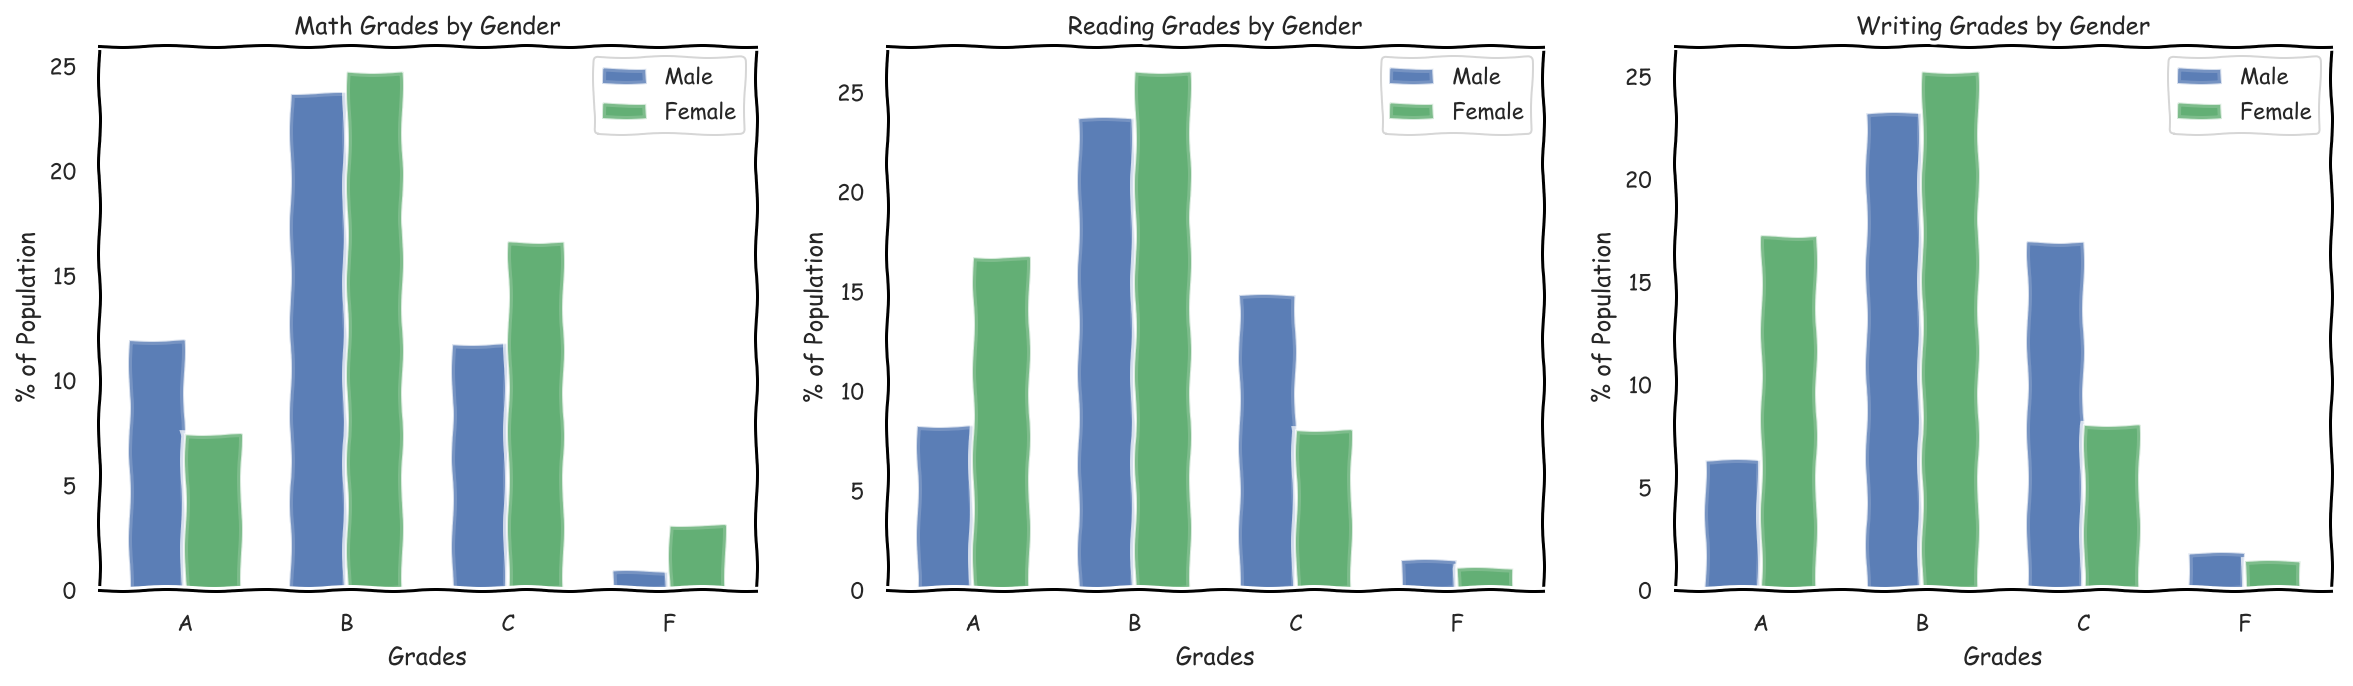

In [23]:
with plt.xkcd():
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    grades = ['A', 'B', 'C', 'F']
    index = np.arange(len(grades))
    bar_width = 0.35

    opacity = 0.7
    error_config = {'ecolor': '0.3'}

    ax[0].bar(index, df_gender_math[df_gender_math['gender'] == 'male']['pc'], bar_width,
                    alpha=opacity, color='b',
                    label='Male')
    ax[0].bar(index + bar_width, df_gender_math[df_gender_math['gender'] == 'female']['pc'], bar_width,
                    alpha=opacity, color='g',
                    label='Female')

    ax[0].set_xlabel('Grades')
    ax[0].set_ylabel('% of Population')
    ax[0].set_title('Math Grades by Gender')
    ax[0].set_xticks(index + bar_width / 2)
    ax[0].set_xticklabels(grades)
    ax[0].legend()
    ax[0].grid(True);

    ax[1].bar(index, df_gender_reading[df_gender_reading['gender'] == 'male']['pc'], bar_width,
                    alpha=opacity, color='b',
                    label='Male')
    ax[1].bar(index + bar_width, df_gender_reading[df_gender_reading['gender'] == 'female']['pc'], bar_width,
                    alpha=opacity, color='g',
                    label='Female')

    ax[1].set_xlabel('Grades')
    ax[1].set_ylabel('% of Population')
    ax[1].set_title('Reading Grades by Gender')
    ax[1].set_xticks(index + bar_width / 2)
    ax[1].set_xticklabels(grades)
    ax[1].legend()
    ax[1].grid(True);

    ax[2].bar(index, df_gender_writing[df_gender_writing['gender'] == 'male']['pc'], bar_width,
                    alpha=opacity, color='b',
                    label='Male')
    ax[2].bar(index + bar_width, df_gender_writing[df_gender_writing['gender'] == 'female']['pc'], bar_width,
                    alpha=opacity, color='g',
                    label='Female')

    ax[2].set_xlabel('Grades')
    ax[2].set_ylabel('% of Population')
    ax[2].set_title('Writing Grades by Gender')
    ax[2].set_xticks(index + bar_width / 2)
    ax[2].set_xticklabels(grades)
    ax[2].legend()
    ax[2].grid(True);
    fig.savefig('images/grades_by_gender.png', dpi=200, bbox_inches='tight');

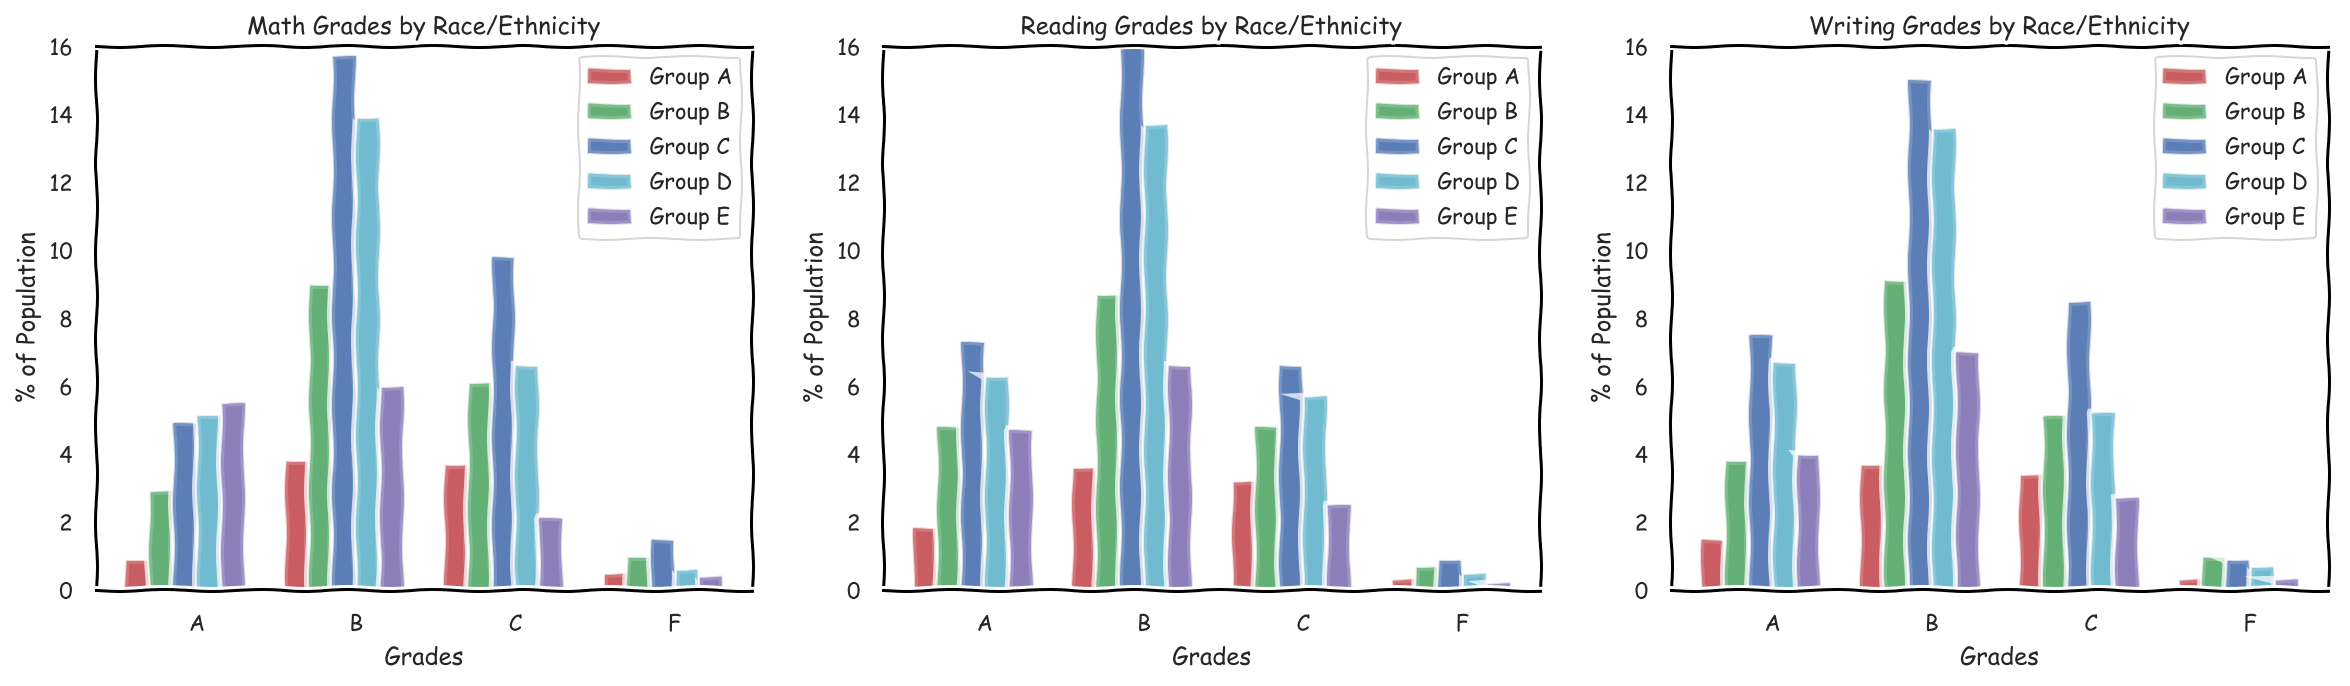

In [24]:
with plt.xkcd():
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    grades = ['A', 'B', 'C', 'F']
    index = np.arange(len(grades))
    bar_width = 0.15

    opacity = 0.7
    error_config = {'ecolor': '0.3'}

    ax[0].bar(index, df_race_math[df_race_math['race/ethnicity'] == 'group A']['pc'], bar_width,
                    alpha=opacity, color='r',
                    label='Group A')
    ax[0].bar(index + bar_width, df_race_math[df_race_math['race/ethnicity'] == 'group B']['pc'], bar_width,
                    alpha=opacity, color='g',
                    label='Group B')
    ax[0].bar(index + bar_width * 2, df_race_math[df_race_math['race/ethnicity'] == 'group C']['pc'], bar_width,
                    alpha=opacity, color='b',
                    label='Group C')
    ax[0].bar(index + bar_width * 3, df_race_math[df_race_math['race/ethnicity'] == 'group D']['pc'], bar_width,
                    alpha=opacity, color='c',
                    label='Group D')
    ax[0].bar(index + bar_width * 4, df_race_math[df_race_math['race/ethnicity'] == 'group E']['pc'], bar_width,
                    alpha=opacity, color='m',
                    label='Group E')

    ax[0].set_xlabel('Grades')
    ax[0].set_ylabel('% of Population')
    ax[0].set_title('Math Grades by Race/Ethnicity')
    ax[0].set_xticks(index + bar_width * 2.5)
    ax[0].set_xticklabels(grades)
    ax[0].legend()
    ax[0].set_ylim([0, 16])
    ax[0].grid(True);

    ax[1].bar(index, df_race_reading[df_race_reading['race/ethnicity'] == 'group A']['pc'], bar_width,
                    alpha=opacity, color='r',
                    label='Group A')
    ax[1].bar(index + bar_width, df_race_reading[df_race_reading['race/ethnicity'] == 'group B']['pc'], bar_width,
                    alpha=opacity, color='g',
                    label='Group B')
    ax[1].bar(index + bar_width * 2, df_race_reading[df_race_reading['race/ethnicity'] == 'group C']['pc'], bar_width,
                    alpha=opacity, color='b',
                    label='Group C')
    ax[1].bar(index + bar_width * 3, df_race_reading[df_race_reading['race/ethnicity'] == 'group D']['pc'], bar_width,
                    alpha=opacity, color='c',
                    label='Group D')
    ax[1].bar(index + bar_width * 4, df_race_reading[df_race_reading['race/ethnicity'] == 'group E']['pc'], bar_width,
                    alpha=opacity, color='m',
                    label='Group E')

    ax[1].set_xlabel('Grades')
    ax[1].set_ylabel('% of Population')
    ax[1].set_title('Reading Grades by Race/Ethnicity')
    ax[1].set_xticks(index + bar_width * 2.5)
    ax[1].set_xticklabels(grades)
    ax[1].legend()
    ax[1].set_ylim([0, 16])
    ax[1].grid(True);

    ax[2].bar(index, df_race_writing[df_race_writing['race/ethnicity'] == 'group A']['pc'], bar_width,
                    alpha=opacity, color='r',
                    label='Group A')
    ax[2].bar(index + bar_width, df_race_writing[df_race_writing['race/ethnicity'] == 'group B']['pc'], bar_width,
                    alpha=opacity, color='g',
                    label='Group B')
    ax[2].bar(index + bar_width * 2, df_race_writing[df_race_writing['race/ethnicity'] == 'group C']['pc'], bar_width,
                    alpha=opacity, color='b',
                    label='Group C')
    ax[2].bar(index + bar_width * 3, df_race_writing[df_race_writing['race/ethnicity'] == 'group D']['pc'], bar_width,
                    alpha=opacity, color='c',
                    label='Group D')
    ax[2].bar(index + bar_width * 4, df_race_writing[df_race_writing['race/ethnicity'] == 'group E']['pc'], bar_width,
                    alpha=opacity, color='m',
                    label='Group E')

    ax[2].set_xlabel('Grades')
    ax[2].set_ylabel('% of Population')
    ax[2].set_title('Writing Grades by Race/Ethnicity')
    ax[2].set_xticks(index + bar_width * 2.5)
    ax[2].set_xticklabels(grades)
    ax[2].legend()
    ax[2].set_ylim([0, 16])
    ax[2].grid(True);
    fig.savefig('images/grades_by_race.png', dpi=200, bbox_inches='tight');

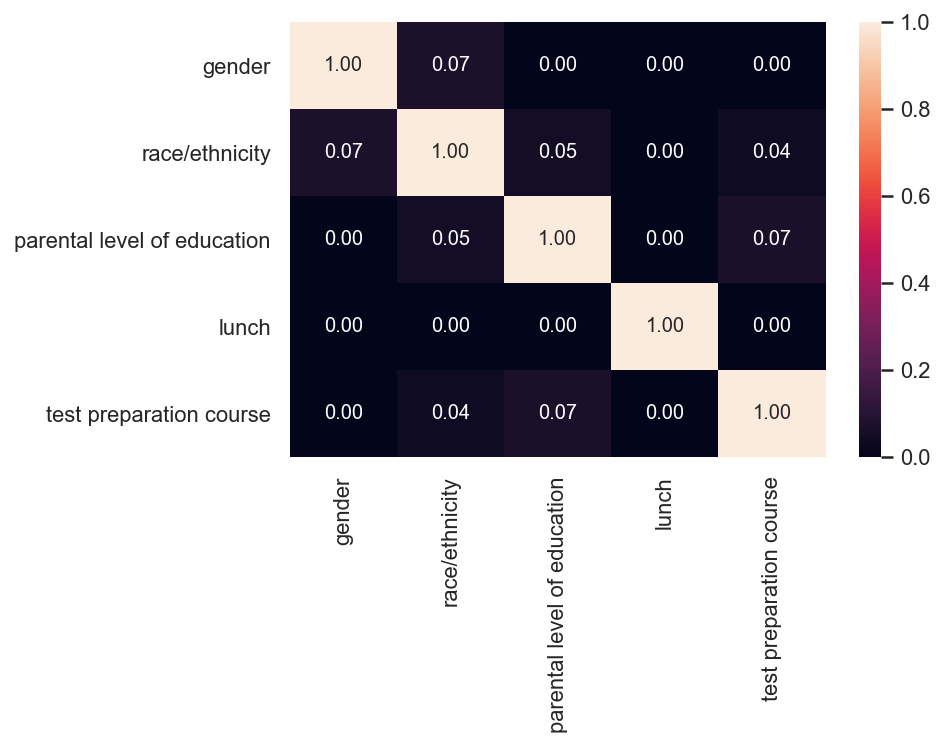

In [25]:
feature_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
f, ax = associations(df[feature_cols], 
             nominal_columns='all', mark_columns=False, theil_u=False, plot=True,
             return_results = False)
f.savefig('images/categorical_correlation.png', dpi=200, bbox_inches='tight')

# Data Preparation

In [26]:
# First, encode the input features
gender_le = LabelEncoder()
race_le = LabelEncoder()
parent_le = LabelEncoder()
lunch_le = LabelEncoder()
test_prep_le = LabelEncoder()

gender_le.fit(df['gender'])
race_le.fit(df['race/ethnicity'])
parent_le.fit(df['parental level of education'])
lunch_le.fit(df['lunch'])
test_prep_le.fit(df['test preparation course'])

df['gender_le'] = gender_le.transform(df['gender'])
df['race_le'] = race_le.transform(df['race/ethnicity'])
df['parent_le'] = parent_le.transform(df['parental level of education'])
df['lunch_le'] = lunch_le.transform(df['lunch'])
df['test_prep_le'] = test_prep_le.transform(df['test preparation course']);

In [27]:
# Next, encode the target variables
math_grade_le = LabelEncoder()
reading_grade_le = LabelEncoder()
writing_grade_le = LabelEncoder()

math_grade_le.fit(df['math grade'])
reading_grade_le.fit(df['reading grade'])
writing_grade_le.fit(df['writing grade'])

df['math_grade_le'] = math_grade_le.transform(df['math grade'])
df['reading_grade_le'] = reading_grade_le.transform(df['reading grade'])
df['writing_grade_le'] = writing_grade_le.transform(df['writing grade'])

In [28]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math grade,reading grade,writing grade,gender_le,race_le,parent_le,lunch_le,test_prep_le,math_grade_le,reading_grade_le,writing_grade_le
0,female,group B,bachelor's degree,standard,none,72,72,74,B,B,B,0,1,1,1,1,1,1,1
1,female,group C,some college,standard,completed,69,90,88,B,A,A,0,2,4,1,0,1,0,0
2,female,group B,master's degree,standard,none,90,95,93,A,A,A,0,1,3,1,1,0,0,0
3,male,group A,associate's degree,free/reduced,none,47,57,44,C,C,C,1,0,0,0,1,2,2,2
4,male,group C,some college,standard,none,76,78,75,B,B,B,1,2,4,1,1,1,1,1


In [29]:
df_train_val, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train_val = df_train_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [30]:
feature_cols = ['gender_le', 'race_le', 'parent_le', 'lunch_le', 'test_prep_le']

X_train_val = df_train_val[feature_cols]
X_test = df_test[feature_cols]
y_math_train_val = df_train_val['math_grade_le']
y_reading_train_val = df_train_val['reading_grade_le']
y_writing_train_val = df_train_val['writing_grade_le']
y_math_test = df_test['math_grade_le']
y_reading_test = df_test['reading_grade_le']
y_writing_test = df_test['writing_grade_le']

# Train Models

## Math Grade Model

In [33]:
# Perform grid search to determine 'optimum' hyperparameters
math_model_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                      ('rf_cls', RandomForestClassifier(random_state=42, n_jobs=4, verbose=1))])

# round 1
# n_estimators = [10, 50, 100, 1000]
# criteria = ['gini', 'entropy'] 
# max_depths = [None, 10, 100, 1000] 

# round 2
# n_estimators = np.arange(50, 101, 10)
# criteria = ['entropy', ]
# max_depths = [10, ]

# round 3
# n_estimators = np.arange(30, 56, 5)
# criteria = ['entropy', ]
# max_depths = [10, ]

# round 4
n_estimators = np.arange(45, 55, 1)
criteria = ['entropy', ]
max_depths = [10, ]

estimator  = GridSearchCV(math_model_pipeline, cv=5, n_jobs=4, verbose=5, param_grid=dict(
                          rf_cls__n_estimators=n_estimators,
                          rf_cls__criterion=criteria,
                          rf_cls__max_depth=max_depths))
estimator.fit(X_train_val, y_math_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   38.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   43.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  51 out of  51 | elapsed:    0.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf_cls', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decr...timators=10, n_jobs=4,
            oob_score=False, random_state=42, verbose=1, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'rf_cls__n_estimators': array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54]), 'rf_cls__criterion': ['entropy'], 'rf_cls__max_depth': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [34]:
# round 1: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 50}
# round 2: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 50}
# round 3: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 50}
# round 4: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 51}
estimator.best_params_

{'rf_cls__criterion': 'entropy',
 'rf_cls__max_depth': 10,
 'rf_cls__n_estimators': 51}

In [35]:
best_math_model = estimator.best_estimator_

In [36]:
best_math_model

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf_cls', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=51, n_jobs=4,
            oob_score=False, random_state=42, verbose=1, warm_start=False))])

In [37]:
y_math_model_test = best_math_model.predict(X_test)
y_math_model_proba_test = best_math_model.predict_proba(X_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  51 out of  51 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  51 out of  51 | elapsed:    0.0s finished


In [38]:
print(y_math_model_test)

[2 1 1 1 0 1 0 1 1 1 2 0 1 1 1 0 1 1 1 2 1 1 1 2 1 0 1 2 1 1 1 1 2 1 1 1 1
 1 1 2 0 1 1 2 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 2 2 1 1 1 1 1 2 1 0 1 1 1
 1 0 1 1 1 1 1 2 2 2 1 2 1 1 2 2 1 1 1 3 1 0 1 2 2 1 0 1 2 2 1 2 0 1 1 1 1
 3 1 2 3 1 2 1 1 1 2 3 0 2 0 0 0 2 0 1 1 0 2 0 2 2 0 1 2 1 1 1 1 1 1 2 1 0
 0 1 0 2 0 1 1 1 3 2 1 0 0 1 1 2 1 1 2 2 0 2 1 0 1 2 1 2 1 2 0 2 2 2 2 2 0
 0 1 1 1 1 1 1 1 1 1 1 0 1 2 0]


In [39]:
print(y_math_test.values)

[0 2 0 1 0 0 1 2 0 2 2 3 1 2 0 1 2 2 2 2 1 2 2 3 0 0 1 2 3 2 1 1 1 1 0 2 1
 1 1 3 0 1 1 2 0 2 1 3 0 1 1 1 1 2 1 1 0 2 0 0 2 1 0 2 0 1 2 2 2 0 1 0 2 3
 1 1 0 2 2 2 1 2 0 1 1 1 1 1 1 3 1 0 1 1 3 1 1 2 1 2 1 1 1 1 1 1 2 1 1 2 3
 1 2 2 1 1 2 2 1 1 2 1 0 1 1 1 1 1 1 1 1 0 2 0 1 3 1 0 1 2 2 2 2 2 0 2 2 1
 2 1 1 1 1 1 1 1 2 2 1 2 2 1 1 2 0 1 2 0 2 1 0 1 1 1 1 3 2 1 0 1 2 1 0 2 0
 1 1 2 0 0 2 1 1 1 1 2 1 1 1 1]


In [45]:
print(feature_cols)
best_math_model.named_steps['rf_cls'].feature_importances_ * 100

['gender_le', 'race_le', 'parent_le', 'lunch_le', 'test_prep_le']


array([ 8.31374744, 32.65158671, 35.81574359, 15.1566664 ,  8.06225586])

In [48]:
dump(best_math_model, 'models/math_model.joblib')

['models/math_model.joblib']

## Reading Grade Model

In [56]:
# Perform grid search to determine 'optimum' hyperparameters
reading_model_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                         ('rf_cls', RandomForestClassifier(random_state=42, n_jobs=4, verbose=1))])

# round 1
# n_estimators = [10, 50, 100, 1000]
# criteria = ['gini', 'entropy'] 
# max_depths = [None, 10, 100, 1000] 

# round 2
# n_estimators = np.arange(50, 101, 10)
# criteria = ['entropy', ]
# max_depths = [10, ]

# round 3
# n_estimators = np.arange(80, 100, 5)
# criteria = ['entropy', ]
# max_depths = [10, ]

# round 4
n_estimators = np.arange(85, 95, 1)
criteria = ['entropy', ]
max_depths = [10, ]

estimator = GridSearchCV(reading_model_pipeline, cv=5, n_jobs=4, verbose=5, param_grid=dict(
                         rf_cls__n_estimators=n_estimators,
                         rf_cls__criterion=criteria,
                         rf_cls__max_depth=max_depths))
estimator.fit(X_train_val, y_reading_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   38.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   44.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    0.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf_cls', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decr...timators=10, n_jobs=4,
            oob_score=False, random_state=42, verbose=1, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'rf_cls__n_estimators': array([85, 86, 87, 88, 89, 90, 91, 92, 93, 94]), 'rf_cls__criterion': ['entropy'], 'rf_cls__max_depth': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [57]:
# round 1: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 50}
# round 2: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 90}
# round 3: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 90}
# round 4: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 92}
estimator.best_params_

{'rf_cls__criterion': 'entropy',
 'rf_cls__max_depth': 10,
 'rf_cls__n_estimators': 92}

In [58]:
best_reading_model = estimator.best_estimator_
best_reading_model

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf_cls', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=92, n_jobs=4,
            oob_score=False, random_state=42, verbose=1, warm_start=False))])

In [59]:
y_reading_model_test = best_reading_model.predict(X_test)
y_reading_model_proba_test = best_reading_model.predict_proba(X_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  92 out of  92 | elapsed:    0.0s finished


In [60]:
print(y_reading_model_test)

[1 1 1 1 1 1 1 1 1 2 2 0 2 0 2 0 1 1 1 2 1 0 1 1 1 1 1 1 0 0 2 2 2 1 1 1 1
 0 1 2 1 2 1 2 1 0 2 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0
 1 1 1 2 0 1 1 2 2 1 1 1 1 1 2 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 0 1 0 1 1 2 1 1 1 1 2 0 1 1 0 2 2 0 1 1 1 1 1 1 2 1
 1 0 0 1 1 1 1 1 2 2 1 0 0 1 1 1 2 1 2 2 0 2 2 1 0 1 1 0 1 1 0 2 1 1 1 1 1
 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0]


In [61]:
print(y_reading_test.values)

[0 1 1 1 0 1 1 1 1 2 2 3 0 1 0 1 2 2 2 1 1 2 1 2 1 1 1 2 2 2 1 1 1 1 1 2 1
 1 1 3 1 1 1 1 0 1 1 3 0 0 1 1 1 2 1 1 1 2 0 0 2 0 1 1 0 1 1 2 1 0 1 0 2 2
 1 1 0 2 1 2 1 3 1 1 1 1 1 1 0 3 0 0 2 1 3 1 1 1 0 1 1 2 2 1 1 1 2 0 0 1 2
 0 2 2 0 2 2 2 1 1 1 1 0 1 1 1 1 1 2 1 0 1 2 0 1 2 0 0 1 2 2 1 2 2 1 1 3 1
 2 0 1 0 1 1 0 1 2 1 1 2 1 1 1 2 0 1 2 0 1 1 0 1 0 0 2 3 2 0 0 0 1 1 0 1 0
 2 1 2 1 0 2 2 1 1 2 2 2 0 1 1]


In [62]:
print(feature_cols)
best_reading_model.named_steps['rf_cls'].feature_importances_ * 100

['gender_le', 'race_le', 'parent_le', 'lunch_le', 'test_prep_le']


array([ 9.63597513, 33.29104359, 37.33067355,  9.95322631,  9.78908142])

In [63]:
dump(best_reading_model, 'models/reading_model.joblib')

['models/reading_model.joblib']

## Writing Grade Model

In [70]:
# Perform grid search to determine 'optimum' hyperparameters
writing_model_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                         ('rf_cls', RandomForestClassifier(random_state=42, n_jobs=4, verbose=1))])

# round 1
# n_estimators = [10, 50, 100, 1000]
# criteria = ['gini', 'entropy'] 
# max_depths = [None, 10, 100, 1000] 

# round 2
# n_estimators = np.arange(50, 101, 10)
# criteria = ['entropy', ]
# max_depths = [10, ]

# round 3
# n_estimators = np.arange(30, 60, 5)
# criteria = ['entropy', ]
# max_depths = [10, ]

# round 4
n_estimators = np.arange(45, 55, 1)
criteria = ['entropy', ]
max_depths = [10, ]

estimator = GridSearchCV(writing_model_pipeline, cv=5, n_jobs=4, verbose=5, param_grid=dict(
                         rf_cls__n_estimators=n_estimators,
                         rf_cls__criterion=criteria,
                         rf_cls__max_depth=max_depths))
estimator.fit(X_train_val, y_writing_train_val)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   37.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   41.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf_cls', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decr...timators=10, n_jobs=4,
            oob_score=False, random_state=42, verbose=1, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'rf_cls__n_estimators': array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54]), 'rf_cls__criterion': ['entropy'], 'rf_cls__max_depth': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [71]:
# round 1: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 50}
# round 2: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 50}
# round 3: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 50}
# round 4: {'rf_cls__criterion': 'entropy', 'rf_cls__max_depth': 10, 'rf_cls__n_estimators': 50}
estimator.best_params_

{'rf_cls__criterion': 'entropy',
 'rf_cls__max_depth': 10,
 'rf_cls__n_estimators': 50}

In [72]:
best_writing_model = estimator.best_estimator_
best_writing_model

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf_cls', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
            oob_score=False, random_state=42, verbose=1, warm_start=False))])

In [73]:
y_writing_model_test = best_writing_model.predict(X_test)
y_writing_model_proba_test = best_writing_model.predict_proba(X_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


In [74]:
print(y_writing_model_test)

[2 1 2 1 1 1 1 1 2 2 2 1 1 1 1 0 1 1 0 2 1 0 1 2 1 1 1 2 0 1 2 1 2 2 2 1 1
 0 1 2 0 2 1 1 1 1 2 1 1 1 1 1 0 1 1 0 2 1 1 0 1 1 2 1 1 0 1 2 1 1 0 0 1 1
 1 1 0 1 1 2 1 2 2 1 2 2 0 1 1 2 2 1 2 2 1 1 1 1 2 1 0 2 2 1 1 2 1 1 1 1 0
 1 1 2 1 1 1 1 1 1 2 1 0 1 0 1 0 1 1 1 0 1 2 0 2 2 0 2 2 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 2 2 1 1 0 1 0 1 1 1 2 2 0 1 2 1 0 1 1 2 1 1 1 1 1 2 1 1 1
 1 0 0 1 1 1 1 2 0 1 1 0 1 2 0]


In [75]:
print(y_writing_test.values)

[0 1 1 1 1 1 1 1 1 2 2 3 0 1 0 0 2 2 2 1 1 2 1 2 1 1 1 2 2 1 2 1 2 1 1 2 1
 1 1 3 1 1 1 1 1 1 1 3 0 1 1 1 1 2 1 1 0 2 1 0 2 0 1 1 0 0 1 2 1 0 1 0 2 2
 2 1 0 2 1 2 1 3 1 1 1 1 1 1 0 3 1 0 2 1 3 1 2 1 1 1 1 2 2 1 1 1 2 1 1 2 2
 0 2 1 0 2 2 2 1 0 1 1 0 1 1 1 0 1 2 1 0 1 2 0 1 2 0 1 1 2 2 1 2 2 1 2 3 1
 2 1 0 0 2 2 0 1 2 1 1 2 1 1 0 2 0 1 2 0 1 0 1 1 0 0 2 3 2 0 0 1 1 1 0 1 0
 2 1 1 1 0 2 2 1 1 2 2 2 1 1 1]


In [76]:
print(feature_cols)
best_writing_model.named_steps['rf_cls'].feature_importances_ * 100

['gender_le', 'race_le', 'parent_le', 'lunch_le', 'test_prep_le']


array([11.66587805, 31.01863185, 36.20506617, 10.58325761, 10.52716633])

In [77]:
dump(best_writing_model, 'models/writing_model.joblib')

['models/writing_model.joblib']